In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [4]:
df_BOT = creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [5]:
df_CIC = creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [6]:
model_names = ['UNSW_EA', 'BOT_EA', 'CIC_EA']
test_ids = [1, 2, 3]
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [16]:
def train_model(model, train_loader, val_loader, epochs, weight1, weight2, lr, device, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs1 = model.forward_exit1(inputs)
            loss1 = criterion(outputs1, labels)
            
            outputs2 = model.forward_exit2(inputs)
            loss2 = criterion(outputs2, labels)
                
            total_loss = (weight1 * loss1) + (weight2 * loss2)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs1 = model.forward_exit1(inputs)
                loss1 = criterion(outputs1, labels)
                
                outputs2 = model.forward_exit2(inputs)
                loss2 = criterion(outputs2, labels)
                    
                total_loss = (weight1 * loss1) + (weight2 * loss2)
                
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss/len(val_loader)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1} pois a loss de validação não melhora há {patience} épocas.')
            print(f'A melhor loss de validação foi: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
            
        scheduler.step(epoch_val_loss) 

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_loss_history, val_loss_history

In [17]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    start_time = time.perf_counter()

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            branch_conf, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = branch_conf > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    end_time = time.perf_counter()
    
    total_inference_time = end_time - start_time

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = correct / total_samples
    exit_rate = exited_early_count / total_samples
    
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples,
            'total_inference_time_sec': total_inference_time
        }

In [18]:
# epochs = 500

# model_id = 1

# for test in test_ids:
#     model = IDSBranchyNet()
    
#     if test == 1:
#         weight1 = 1
#         weight2 = 0
#     elif test == 2:
#         weight1 = 0
#         weight2 = 1
#     elif test == 3:
#         weight1 = 1
#         weight2 = 1
    
        
#     print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
    
#     train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, lr=0.0001, device=device, modelname=model_names[model_id])

#     torch.save(model.state_dict(), f'models/{model_names[model_id]}_{test}_v3.pth')
#     print(f"Model saved at 'models/{model_names[model_id]}_{test}_v3.pth'\n")
    

--- Training model: UNSW_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6918, Validation Loss: 0.6884
Epoch [2/500], Train Loss: 0.6832, Validation Loss: 0.6730
Epoch [3/500], Train Loss: 0.6641, Validation Loss: 0.6524
Epoch [4/500], Train Loss: 0.6511, Validation Loss: 0.6418
Epoch [5/500], Train Loss: 0.6433, Validation Loss: 0.6348
Epoch [6/500], Train Loss: 0.6376, Validation Loss: 0.6289
Epoch [7/500], Train Loss: 0.6276, Validation Loss: 0.6200
Epoch [8/500], Train Loss: 0.6230, Validation Loss: 0.6141
Epoch [9/500], Train Loss: 0.6218, Validation Loss: 0.6220
Epoch [10/500], Train Loss: 0.6124, Validation Loss: 0.6074
Epoch [11/500], Train Loss: 0.6053, Validation Loss: 0.6150
Epoch [12/500], Train Loss: 0.6006, Validation Loss: 0.6028
Epoch [13/500], Train Loss: 0.5936, Validation Loss: 0.5884
Epoch [14/500], Train Loss: 0.5869, Validation Loss: 0.6096
Epoch [15/500], Train Loss: 0.5784, Validation Loss: 0.6067
Epoch [16/500], Train Loss: 0.5706, Validati

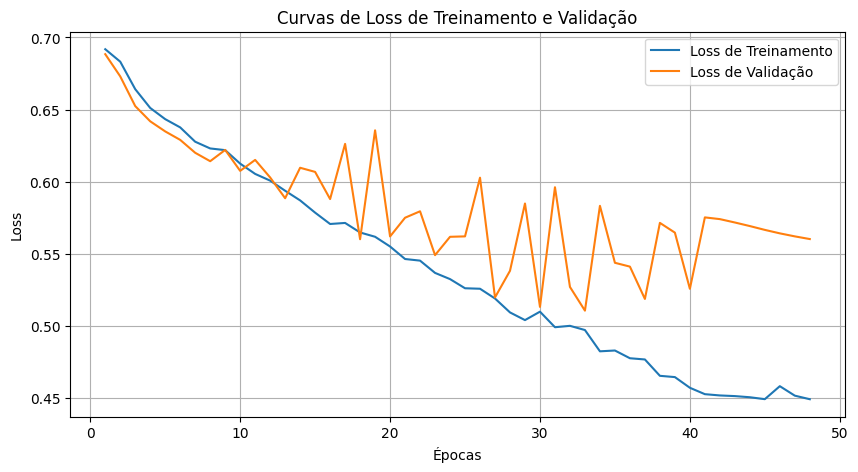

Model saved at 'models/UNSW_EA_2.pth'

--- Training model: BOT_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6931, Validation Loss: 0.6925
Epoch [2/500], Train Loss: 0.6925, Validation Loss: 0.6917
Epoch [3/500], Train Loss: 0.6915, Validation Loss: 0.6900
Epoch [4/500], Train Loss: 0.6899, Validation Loss: 0.6869
Epoch [5/500], Train Loss: 0.6868, Validation Loss: 0.6814
Epoch [6/500], Train Loss: 0.6823, Validation Loss: 0.6723
Epoch [7/500], Train Loss: 0.6738, Validation Loss: 0.6598
Epoch [8/500], Train Loss: 0.6624, Validation Loss: 0.6418
Epoch [9/500], Train Loss: 0.6526, Validation Loss: 0.6196
Epoch [10/500], Train Loss: 0.6399, Validation Loss: 0.5998
Epoch [11/500], Train Loss: 0.6313, Validation Loss: 0.5863
Epoch [12/500], Train Loss: 0.6293, Validation Loss: 0.5779
Epoch [13/500], Train Loss: 0.6231, Validation Loss: 0.5711
Epoch [14/500], Train Loss: 0.6152, Validation Loss: 0.5701
Epoch [15/500], Train Loss: 0.6094, Validation Loss: 0.5647
Epoch 

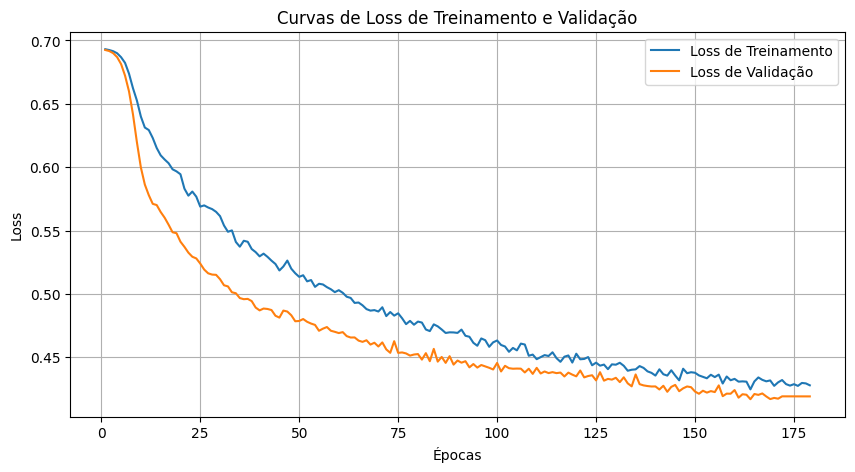

Model saved at 'models/BOT_EA_2.pth'

--- Training model: CIC_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6913, Validation Loss: 0.6863
Epoch [2/500], Train Loss: 0.6776, Validation Loss: 0.6565
Epoch [3/500], Train Loss: 0.6532, Validation Loss: 0.6255
Epoch [4/500], Train Loss: 0.6291, Validation Loss: 0.5944
Epoch [5/500], Train Loss: 0.6105, Validation Loss: 0.5869
Epoch [6/500], Train Loss: 0.6006, Validation Loss: 0.5775
Epoch [7/500], Train Loss: 0.5890, Validation Loss: 0.5662
Epoch [8/500], Train Loss: 0.5792, Validation Loss: 0.5541
Epoch [9/500], Train Loss: 0.5707, Validation Loss: 0.5481
Epoch [10/500], Train Loss: 0.5591, Validation Loss: 0.5387
Epoch [11/500], Train Loss: 0.5525, Validation Loss: 0.5295
Epoch [12/500], Train Loss: 0.5484, Validation Loss: 0.5321
Epoch [13/500], Train Loss: 0.5397, Validation Loss: 0.5262
Epoch [14/500], Train Loss: 0.5350, Validation Loss: 0.5160
Epoch [15/500], Train Loss: 0.5257, Validation Loss: 0.4983
Epoch [

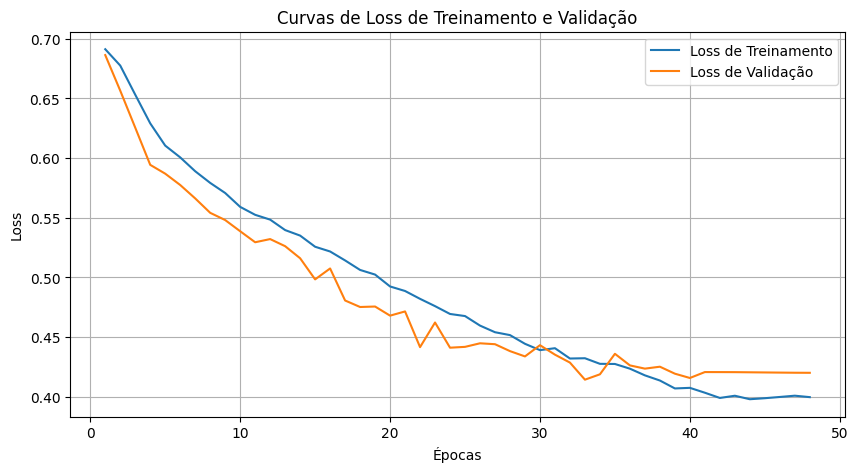

Model saved at 'models/CIC_EA_2.pth'



In [23]:
epochs = 500

weight1 = 0
weight2 = 1

test = 2

for model_id in range(len(model_names)):
    model = IDSBranchyNet()
    
        
    print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
    
    train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, lr=0.0001, device=device)

    torch.save(model.state_dict(), f'models/{model_names[model_id]}_{test}.pth')
    print(f"Model saved at 'models/{model_names[model_id]}_{test}.pth'\n")
    

--- Training model: UNSW_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6952, Validation Loss: 0.6945
Epoch [2/500], Train Loss: 0.6942, Validation Loss: 0.6935
Epoch [3/500], Train Loss: 0.6931, Validation Loss: 0.6925
Epoch [4/500], Train Loss: 0.6922, Validation Loss: 0.6915
Epoch [5/500], Train Loss: 0.6912, Validation Loss: 0.6905
Epoch [6/500], Train Loss: 0.6901, Validation Loss: 0.6895
Epoch [7/500], Train Loss: 0.6889, Validation Loss: 0.6883
Epoch [8/500], Train Loss: 0.6877, Validation Loss: 0.6869
Epoch [9/500], Train Loss: 0.6860, Validation Loss: 0.6855
Epoch [10/500], Train Loss: 0.6848, Validation Loss: 0.6839
Epoch [11/500], Train Loss: 0.6833, Validation Loss: 0.6823
Epoch [12/500], Train Loss: 0.6813, Validation Loss: 0.6805
Epoch [13/500], Train Loss: 0.6796, Validation Loss: 0.6786
Epoch [14/500], Train Loss: 0.6778, Validation Loss: 0.6767
Epoch [15/500], Train Loss: 0.6756, Validation Loss: 0.6746
Epoch [16/500], Train Loss: 0.6736, Validati

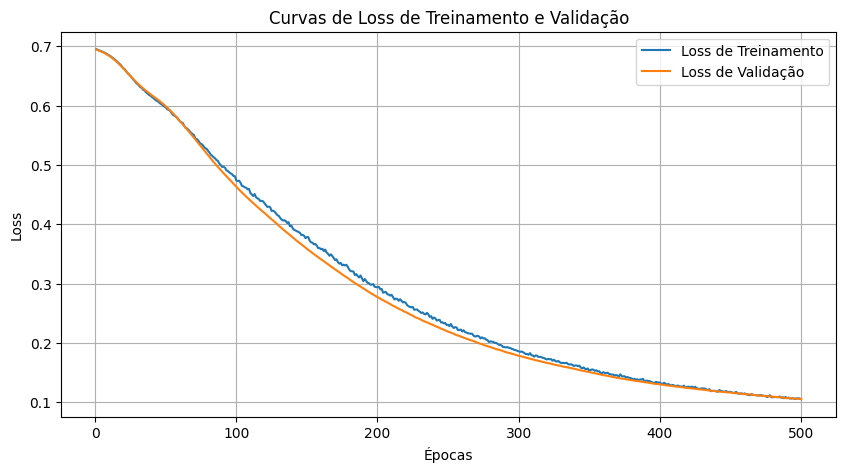

Model saved at 'models/UNSW_EA_1.pth'

--- Training model: UNSW_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6925, Validation Loss: 0.6909
Epoch [2/500], Train Loss: 0.6889, Validation Loss: 0.6850
Epoch [3/500], Train Loss: 0.6777, Validation Loss: 0.6634
Epoch [4/500], Train Loss: 0.6543, Validation Loss: 0.6446
Epoch [5/500], Train Loss: 0.6422, Validation Loss: 0.6293
Epoch [6/500], Train Loss: 0.6335, Validation Loss: 0.6214
Epoch [7/500], Train Loss: 0.6278, Validation Loss: 0.6144
Epoch [8/500], Train Loss: 0.6211, Validation Loss: 0.6064
Epoch [9/500], Train Loss: 0.6125, Validation Loss: 0.5998
Epoch [10/500], Train Loss: 0.6036, Validation Loss: 0.5937
Epoch [11/500], Train Loss: 0.5983, Validation Loss: 0.5916
Epoch [12/500], Train Loss: 0.5817, Validation Loss: 0.5623
Epoch [13/500], Train Loss: 0.5801, Validation Loss: 0.5336
Epoch [14/500], Train Loss: 0.5742, Validation Loss: 0.5863
Epoch [15/500], Train Loss: 0.5690, Validation Loss: 0.5419
Epoch

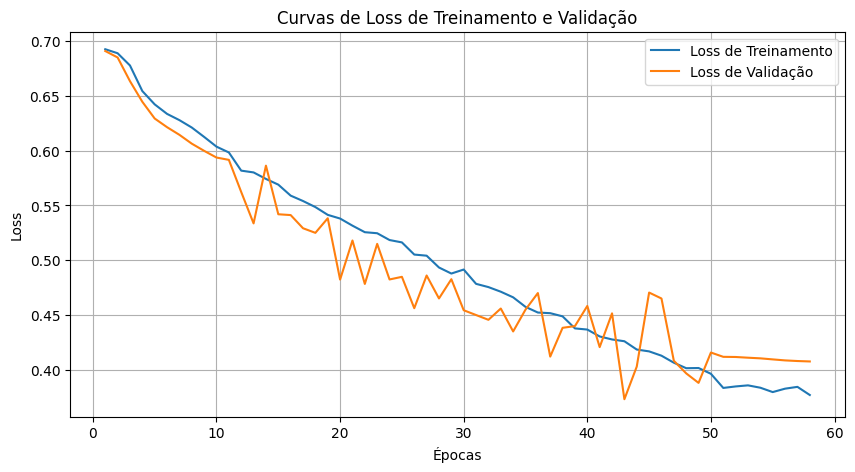

Model saved at 'models/UNSW_EA_2.pth'

--- Training model: UNSW_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3836, Validation Loss: 1.3771
Epoch [2/500], Train Loss: 1.3701, Validation Loss: 1.3519
Epoch [3/500], Train Loss: 1.3450, Validation Loss: 1.3296
Epoch [4/500], Train Loss: 1.3304, Validation Loss: 1.3200
Epoch [5/500], Train Loss: 1.3225, Validation Loss: 1.3128
Epoch [6/500], Train Loss: 1.3163, Validation Loss: 1.3074
Epoch [7/500], Train Loss: 1.3130, Validation Loss: 1.3025
Epoch [8/500], Train Loss: 1.3084, Validation Loss: 1.2988
Epoch [9/500], Train Loss: 1.3011, Validation Loss: 1.2927
Epoch [10/500], Train Loss: 1.2992, Validation Loss: 1.2868
Epoch [11/500], Train Loss: 1.2928, Validation Loss: 1.2799
Epoch [12/500], Train Loss: 1.2889, Validation Loss: 1.2763
Epoch [13/500], Train Loss: 1.2863, Validation Loss: 1.2676
Epoch [14/500], Train Loss: 1.2798, Validation Loss: 1.2610
Epoch [15/500], Train Loss: 1.2761, Validation Loss: 1.2567
Epoch

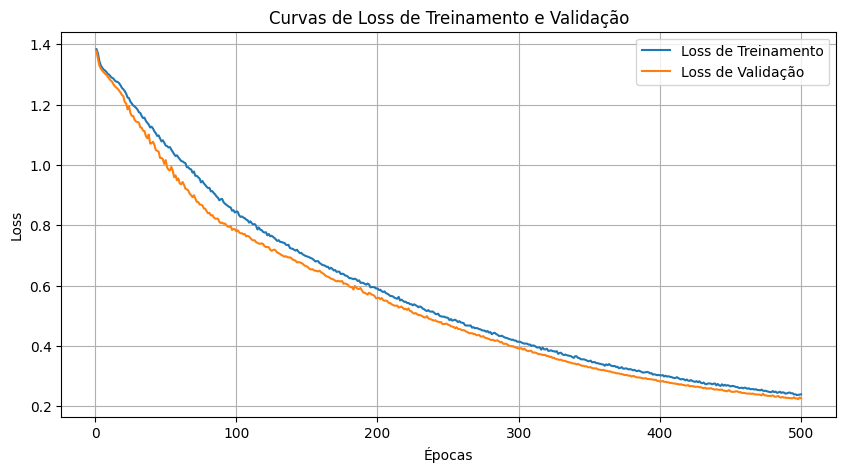

Model saved at 'models/UNSW_EA_3.pth'

--- Training model: BOT_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6926, Validation Loss: 0.6920
Epoch [2/500], Train Loss: 0.6922, Validation Loss: 0.6917
Epoch [3/500], Train Loss: 0.6919, Validation Loss: 0.6914
Epoch [4/500], Train Loss: 0.6917, Validation Loss: 0.6911
Epoch [5/500], Train Loss: 0.6915, Validation Loss: 0.6908
Epoch [6/500], Train Loss: 0.6912, Validation Loss: 0.6905
Epoch [7/500], Train Loss: 0.6909, Validation Loss: 0.6902
Epoch [8/500], Train Loss: 0.6905, Validation Loss: 0.6900
Epoch [9/500], Train Loss: 0.6901, Validation Loss: 0.6897
Epoch [10/500], Train Loss: 0.6900, Validation Loss: 0.6894
Epoch [11/500], Train Loss: 0.6898, Validation Loss: 0.6891
Epoch [12/500], Train Loss: 0.6896, Validation Loss: 0.6888
Epoch [13/500], Train Loss: 0.6893, Validation Loss: 0.6885
Epoch [14/500], Train Loss: 0.6890, Validation Loss: 0.6882
Epoch [15/500], Train Loss: 0.6885, Validation Loss: 0.6879
Epoch 

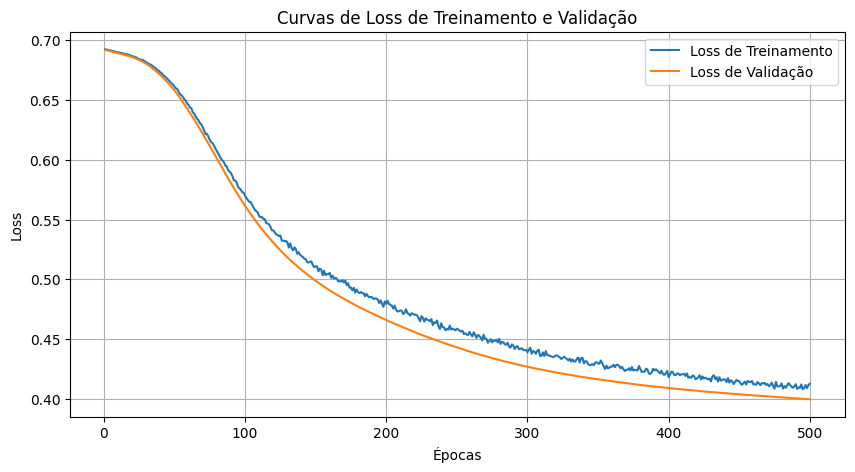

Model saved at 'models/BOT_EA_1.pth'

--- Training model: BOT_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6930, Validation Loss: 0.6925
Epoch [2/500], Train Loss: 0.6925, Validation Loss: 0.6916
Epoch [3/500], Train Loss: 0.6918, Validation Loss: 0.6902
Epoch [4/500], Train Loss: 0.6901, Validation Loss: 0.6874
Epoch [5/500], Train Loss: 0.6875, Validation Loss: 0.6822
Epoch [6/500], Train Loss: 0.6827, Validation Loss: 0.6736
Epoch [7/500], Train Loss: 0.6732, Validation Loss: 0.6585
Epoch [8/500], Train Loss: 0.6610, Validation Loss: 0.6370
Epoch [9/500], Train Loss: 0.6459, Validation Loss: 0.6226
Epoch [10/500], Train Loss: 0.6410, Validation Loss: 0.5964
Epoch [11/500], Train Loss: 0.6265, Validation Loss: 0.5892
Epoch [12/500], Train Loss: 0.6184, Validation Loss: 0.5765
Epoch [13/500], Train Loss: 0.6173, Validation Loss: 0.5726
Epoch [14/500], Train Loss: 0.6076, Validation Loss: 0.5662
Epoch [15/500], Train Loss: 0.6039, Validation Loss: 0.5586
Epoch [

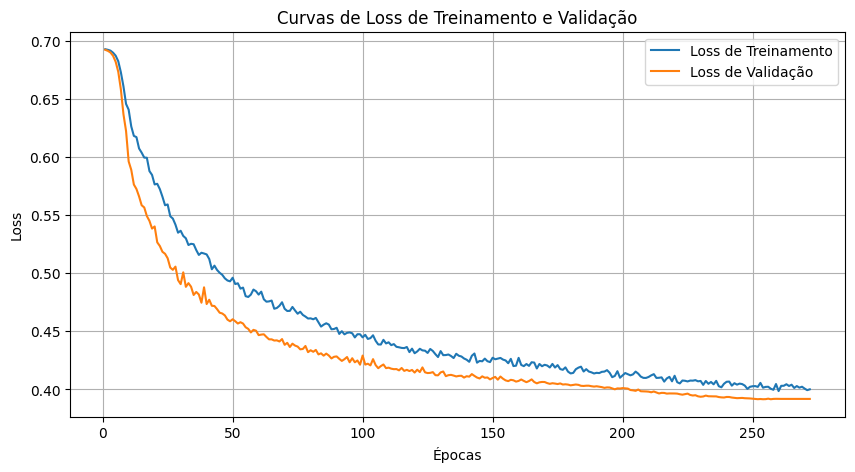

Model saved at 'models/BOT_EA_2.pth'

--- Training model: BOT_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3917, Validation Loss: 1.3907
Epoch [2/500], Train Loss: 1.3905, Validation Loss: 1.3892
Epoch [3/500], Train Loss: 1.3888, Validation Loss: 1.3869
Epoch [4/500], Train Loss: 1.3870, Validation Loss: 1.3835
Epoch [5/500], Train Loss: 1.3830, Validation Loss: 1.3768
Epoch [6/500], Train Loss: 1.3772, Validation Loss: 1.3664
Epoch [7/500], Train Loss: 1.3665, Validation Loss: 1.3499
Epoch [8/500], Train Loss: 1.3567, Validation Loss: 1.3291
Epoch [9/500], Train Loss: 1.3415, Validation Loss: 1.3024
Epoch [10/500], Train Loss: 1.3299, Validation Loss: 1.2815
Epoch [11/500], Train Loss: 1.3187, Validation Loss: 1.2690
Epoch [12/500], Train Loss: 1.3180, Validation Loss: 1.2657
Epoch [13/500], Train Loss: 1.3073, Validation Loss: 1.2639
Epoch [14/500], Train Loss: 1.3046, Validation Loss: 1.2541
Epoch [15/500], Train Loss: 1.2988, Validation Loss: 1.2485
Epoch [

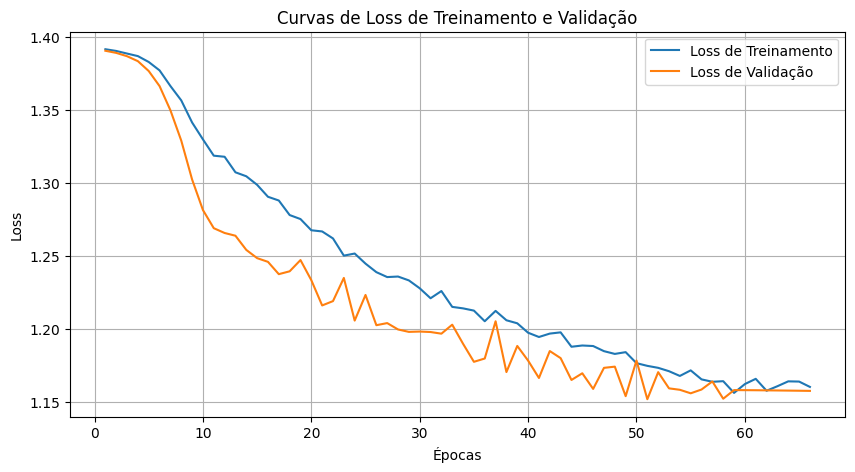

Model saved at 'models/BOT_EA_3.pth'

--- Training model: CIC_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6948, Validation Loss: 0.6940
Epoch [2/500], Train Loss: 0.6933, Validation Loss: 0.6927
Epoch [3/500], Train Loss: 0.6922, Validation Loss: 0.6914
Epoch [4/500], Train Loss: 0.6909, Validation Loss: 0.6900
Epoch [5/500], Train Loss: 0.6894, Validation Loss: 0.6886
Epoch [6/500], Train Loss: 0.6883, Validation Loss: 0.6872
Epoch [7/500], Train Loss: 0.6867, Validation Loss: 0.6857
Epoch [8/500], Train Loss: 0.6850, Validation Loss: 0.6839
Epoch [9/500], Train Loss: 0.6833, Validation Loss: 0.6819
Epoch [10/500], Train Loss: 0.6814, Validation Loss: 0.6797
Epoch [11/500], Train Loss: 0.6790, Validation Loss: 0.6770
Epoch [12/500], Train Loss: 0.6762, Validation Loss: 0.6739
Epoch [13/500], Train Loss: 0.6732, Validation Loss: 0.6706
Epoch [14/500], Train Loss: 0.6698, Validation Loss: 0.6670
Epoch [15/500], Train Loss: 0.6658, Validation Loss: 0.6629
Epoch [

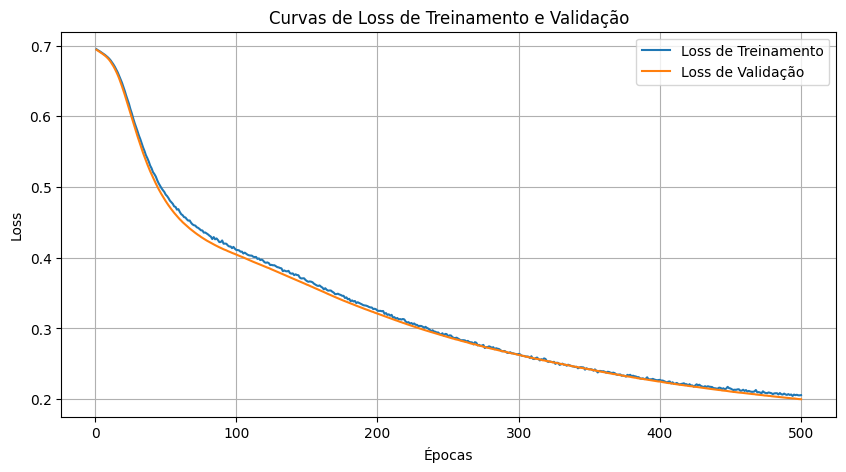

Model saved at 'models/CIC_EA_1.pth'

--- Training model: CIC_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6914, Validation Loss: 0.6867
Epoch [2/500], Train Loss: 0.6758, Validation Loss: 0.6484
Epoch [3/500], Train Loss: 0.6456, Validation Loss: 0.6111
Epoch [4/500], Train Loss: 0.6286, Validation Loss: 0.5915
Epoch [5/500], Train Loss: 0.6119, Validation Loss: 0.5710
Epoch [6/500], Train Loss: 0.5931, Validation Loss: 0.5486
Epoch [7/500], Train Loss: 0.5874, Validation Loss: 0.5371
Epoch [8/500], Train Loss: 0.5736, Validation Loss: 0.5186
Epoch [9/500], Train Loss: 0.5590, Validation Loss: 0.5052
Epoch [10/500], Train Loss: 0.5444, Validation Loss: 0.4951
Epoch [11/500], Train Loss: 0.5331, Validation Loss: 0.4841
Epoch [12/500], Train Loss: 0.5274, Validation Loss: 0.4859
Epoch [13/500], Train Loss: 0.5156, Validation Loss: 0.4607
Epoch [14/500], Train Loss: 0.5081, Validation Loss: 0.4757
Epoch [15/500], Train Loss: 0.5008, Validation Loss: 0.4690
Epoch [

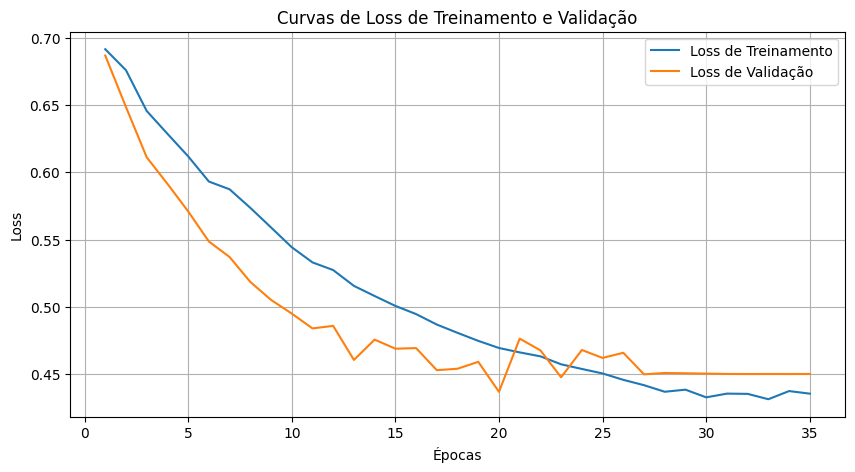

Model saved at 'models/CIC_EA_2.pth'

--- Training model: CIC_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3869, Validation Loss: 1.3848
Epoch [2/500], Train Loss: 1.3826, Validation Loss: 1.3760
Epoch [3/500], Train Loss: 1.3659, Validation Loss: 1.3348
Epoch [4/500], Train Loss: 1.3426, Validation Loss: 1.3039
Epoch [5/500], Train Loss: 1.3216, Validation Loss: 1.2891
Epoch [6/500], Train Loss: 1.3051, Validation Loss: 1.2691
Epoch [7/500], Train Loss: 1.2898, Validation Loss: 1.2562
Epoch [8/500], Train Loss: 1.2812, Validation Loss: 1.2514
Epoch [9/500], Train Loss: 1.2684, Validation Loss: 1.2402
Epoch [10/500], Train Loss: 1.2585, Validation Loss: 1.2373
Epoch [11/500], Train Loss: 1.2498, Validation Loss: 1.2194
Epoch [12/500], Train Loss: 1.2397, Validation Loss: 1.2087
Epoch [13/500], Train Loss: 1.2373, Validation Loss: 1.2134
Epoch [14/500], Train Loss: 1.2258, Validation Loss: 1.1943
Epoch [15/500], Train Loss: 1.2161, Validation Loss: 1.1794
Epoch [

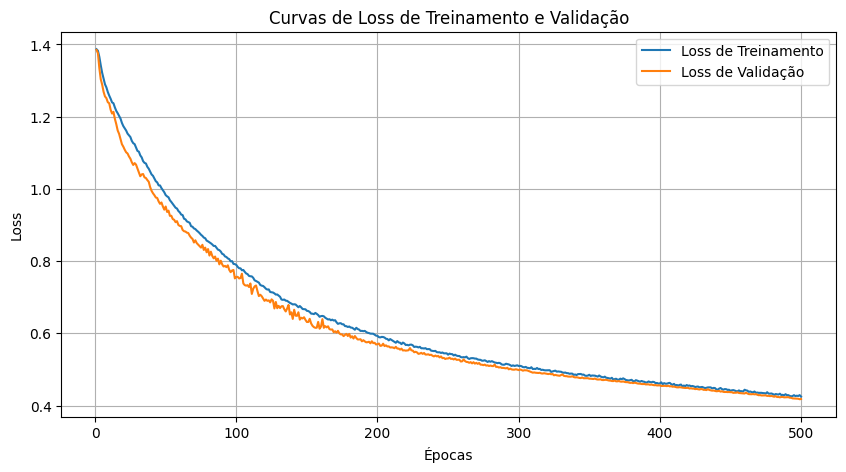

Model saved at 'models/CIC_EA_3.pth'



In [20]:
# epochs = 500

# for model_id in range(len(model_names)):
#     for test in test_ids:
#         model = IDSBranchyNet()
        
#         if test == 1:
#             weight1 = 1
#             weight2 = 0
#         elif test == 2:
#             weight1 = 0
#             weight2 = 1
#         elif test == 3:
#             weight1 = 1
#             weight2 = 1
        
            
#         print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
        
#         train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, lr=0.0001, device=device)

#         torch.save(model.state_dict(), f'models/{model_names[model_id]}_{test}.pth')
#         print(f"Model saved at 'models/{model_names[model_id]}_{test}.pth'\n")
        

In [21]:
# for model_id in range(len(model_names)):
#     for loader in range(len(test_loaders)):
#         print(f"--- Model: {model_names[model_id]} | Loader: {model_names[loader]} | TestID: {test} ---")

#         model.load_state_dict(torch.load(f'models/{model_names[model_id]}_2_v2.pth'))
#         model.to(device)
#         model.eval()
#         print(f"Model from: 'models/{model_names[model_id]}_2_v2.pth' carregado")

#         t=2

#         results = evaluate_model(model, test_loaders[loader], confidence_threshold=t, device=device)
        
#         print("-" * 20)
#         print(f"Threshold: {t:.4f}")
#         print(f"  Accuracy: {results['accuracy']:.4f}")
#         print(f"  Total Inference Time: {results['total_inference_time_sec']:.4f} s")
#         print(f"  Early Exit Rate: {results['exit_rate']:.4f} ({results['exited_early_count']}/{results['total_samples']})")
#         print("-" * 20)
#         print("\n")

0.9622
--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


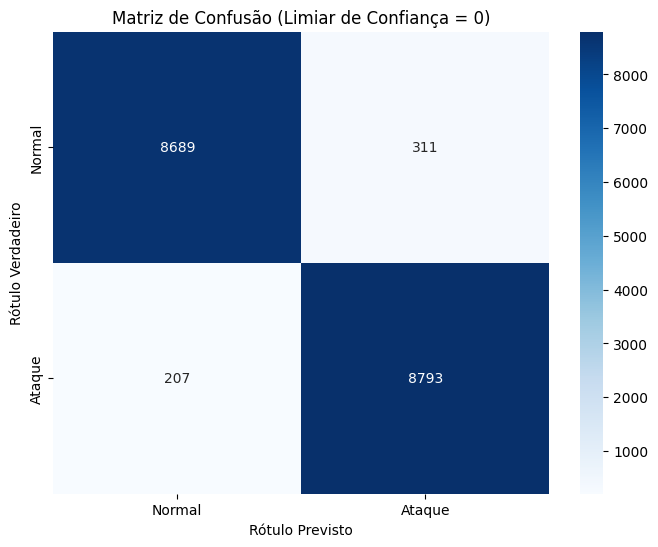

True Positives (TP): 8793
True Negatives (TN): 8689
False Positives (FP): 311
False Negatives (FN): 207

F1 Score: 0.9714
True Positive Rate (TPR) / Recall: 0.9770
True Negative Rate (TNR) / Specificity: 0.9654
--------------------
Threshold: 0.0000
  Accuracy: 0.9712
  Total Inference Time: 0.2573 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


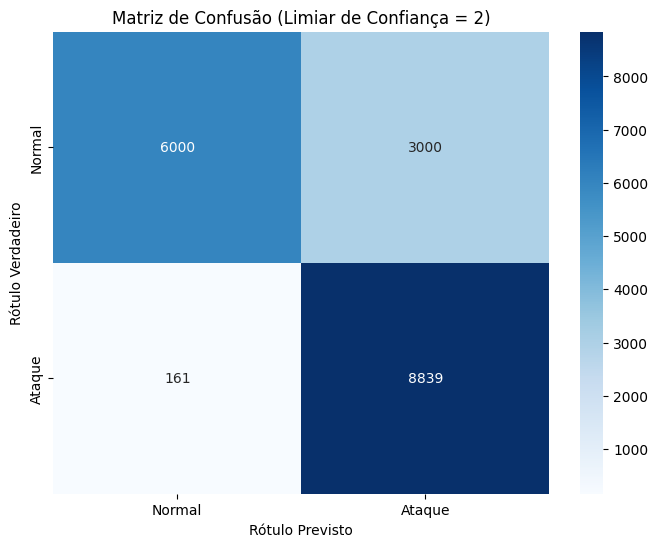

True Positives (TP): 8839
True Negatives (TN): 6000
False Positives (FP): 3000
False Negatives (FN): 161

F1 Score: 0.8483
True Positive Rate (TPR) / Recall: 0.9821
True Negative Rate (TNR) / Specificity: 0.6667
--------------------
Threshold: 2.0000
  Accuracy: 0.8244
  Total Inference Time: 0.1882 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


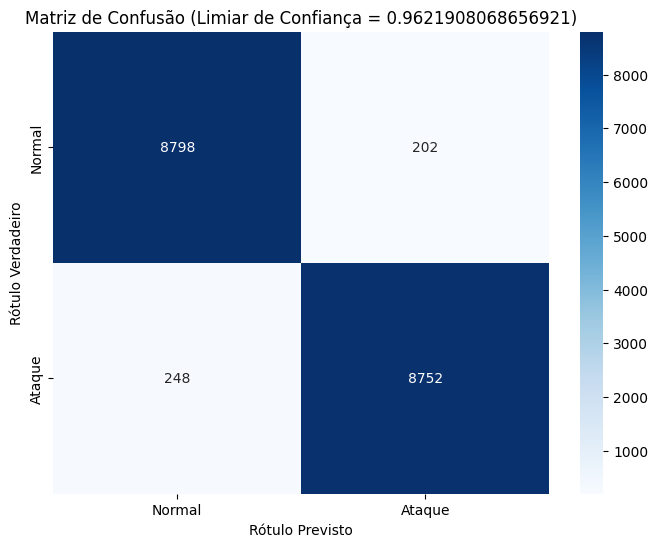

True Positives (TP): 8752
True Negatives (TN): 8798
False Positives (FP): 202
False Negatives (FN): 248

F1 Score: 0.9749
True Positive Rate (TPR) / Recall: 0.9724
True Negative Rate (TNR) / Specificity: 0.9776
--------------------
Threshold: 0.9622
  Accuracy: 0.9750
  Total Inference Time: 0.1599 s
  Early Exit Rate: 0.4200 (7560/18000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


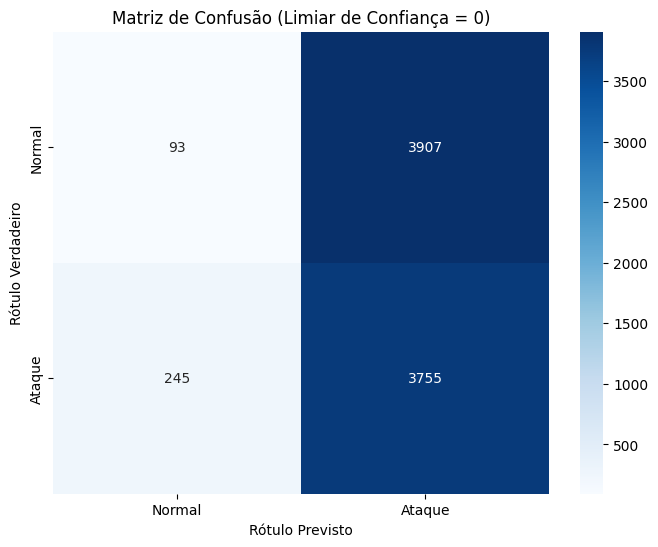

True Positives (TP): 3755
True Negatives (TN): 93
False Positives (FP): 3907
False Negatives (FN): 245

F1 Score: 0.6440
True Positive Rate (TPR) / Recall: 0.9387
True Negative Rate (TNR) / Specificity: 0.0232
--------------------
Threshold: 0.0000
  Accuracy: 0.4810
  Total Inference Time: 0.0616 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


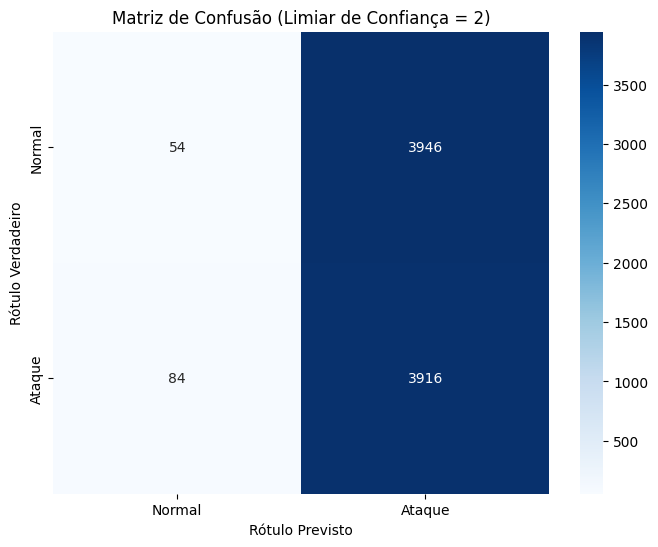

True Positives (TP): 3916
True Negatives (TN): 54
False Positives (FP): 3946
False Negatives (FN): 84

F1 Score: 0.6603
True Positive Rate (TPR) / Recall: 0.9790
True Negative Rate (TNR) / Specificity: 0.0135
--------------------
Threshold: 2.0000
  Accuracy: 0.4963
  Total Inference Time: 0.2804 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


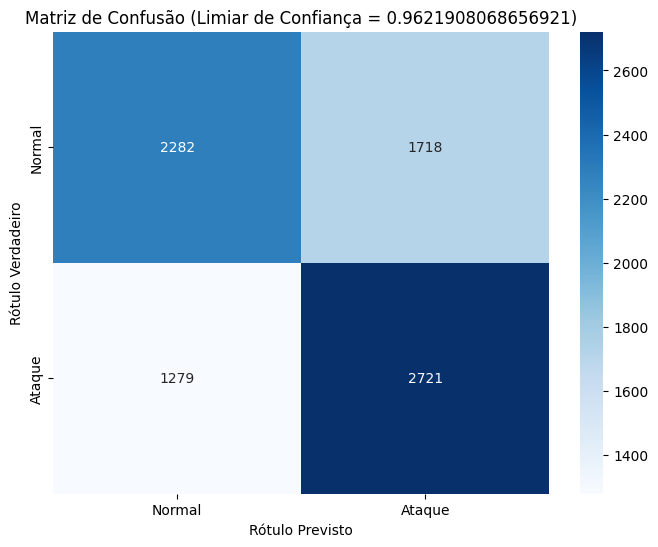

True Positives (TP): 2721
True Negatives (TN): 2282
False Positives (FP): 1718
False Negatives (FN): 1279

F1 Score: 0.6449
True Positive Rate (TPR) / Recall: 0.6803
True Negative Rate (TNR) / Specificity: 0.5705
--------------------
Threshold: 0.9622
  Accuracy: 0.6254
  Total Inference Time: 0.0796 s
  Early Exit Rate: 0.1699 (1359/8000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


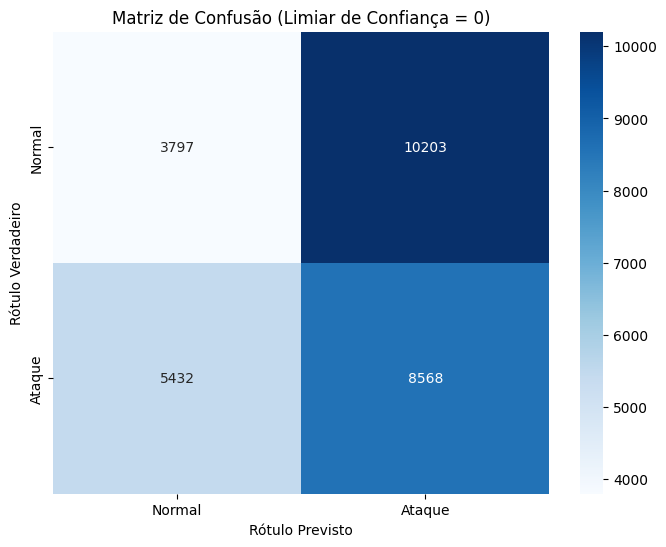

True Positives (TP): 8568
True Negatives (TN): 3797
False Positives (FP): 10203
False Negatives (FN): 5432

F1 Score: 0.5229
True Positive Rate (TPR) / Recall: 0.6120
True Negative Rate (TNR) / Specificity: 0.2712
--------------------
Threshold: 0.0000
  Accuracy: 0.4416
  Total Inference Time: 0.2144 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


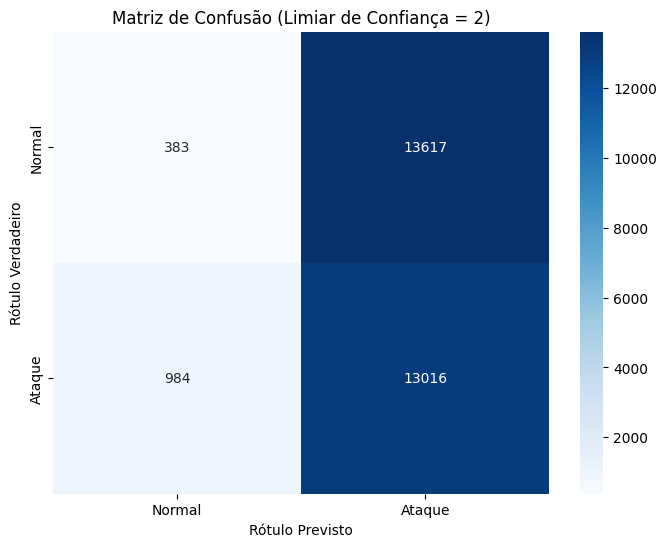

True Positives (TP): 13016
True Negatives (TN): 383
False Positives (FP): 13617
False Negatives (FN): 984

F1 Score: 0.6407
True Positive Rate (TPR) / Recall: 0.9297
True Negative Rate (TNR) / Specificity: 0.0274
--------------------
Threshold: 2.0000
  Accuracy: 0.4785
  Total Inference Time: 0.2736 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


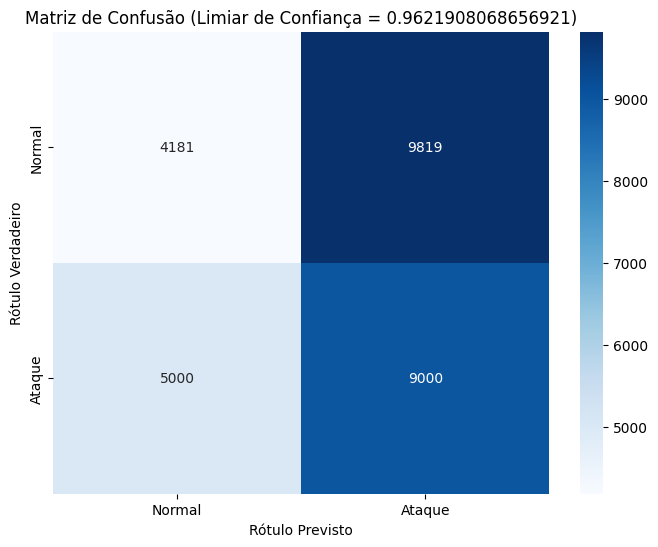

True Positives (TP): 9000
True Negatives (TN): 4181
False Positives (FP): 9819
False Negatives (FN): 5000

F1 Score: 0.5485
True Positive Rate (TPR) / Recall: 0.6429
True Negative Rate (TNR) / Specificity: 0.2986
--------------------
Threshold: 0.9622
  Accuracy: 0.4708
  Total Inference Time: 0.4633 s
  Early Exit Rate: 0.2419 (6774/28000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


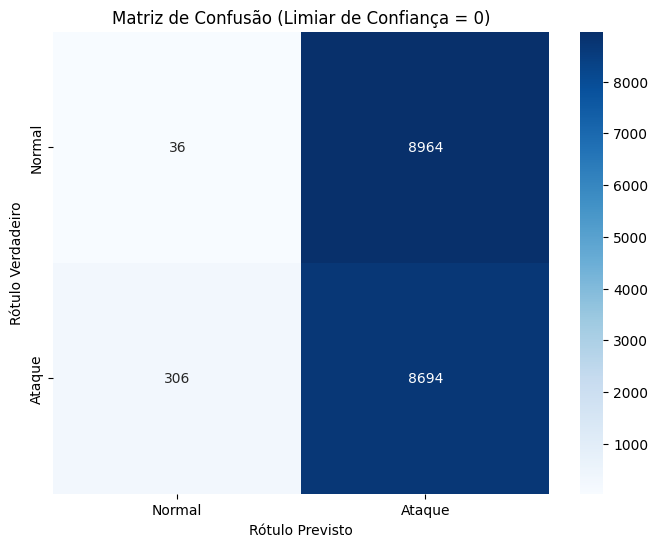

True Positives (TP): 8694
True Negatives (TN): 36
False Positives (FP): 8964
False Negatives (FN): 306

F1 Score: 0.6523
True Positive Rate (TPR) / Recall: 0.9660
True Negative Rate (TNR) / Specificity: 0.0040
--------------------
Threshold: 0.0000
  Accuracy: 0.4850
  Total Inference Time: 0.1368 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


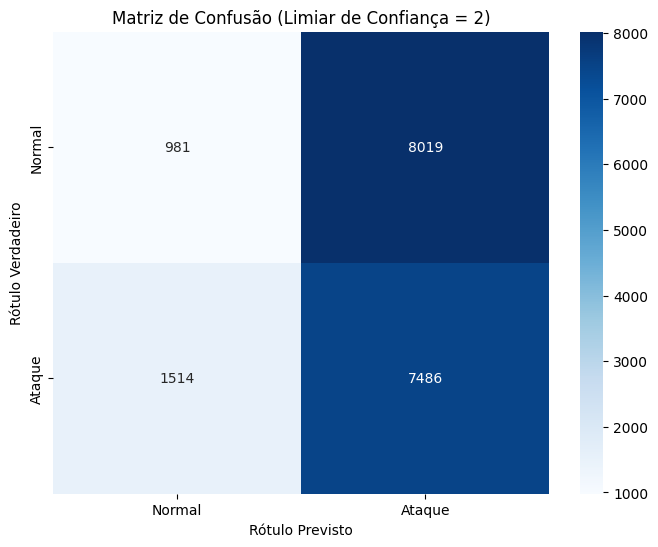

True Positives (TP): 7486
True Negatives (TN): 981
False Positives (FP): 8019
False Negatives (FN): 1514

F1 Score: 0.6110
True Positive Rate (TPR) / Recall: 0.8318
True Negative Rate (TNR) / Specificity: 0.1090
--------------------
Threshold: 2.0000
  Accuracy: 0.4704
  Total Inference Time: 0.1653 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


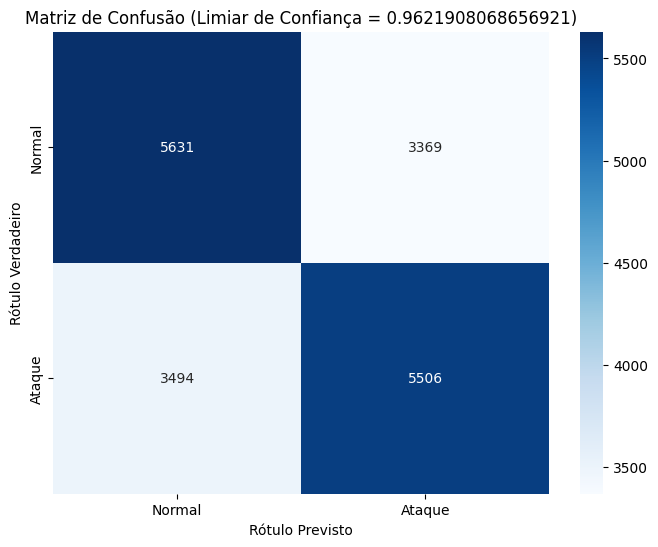

True Positives (TP): 5506
True Negatives (TN): 5631
False Positives (FP): 3369
False Negatives (FN): 3494

F1 Score: 0.6161
True Positive Rate (TPR) / Recall: 0.6118
True Negative Rate (TNR) / Specificity: 0.6257
--------------------
Threshold: 0.9622
  Accuracy: 0.6187
  Total Inference Time: 0.1651 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


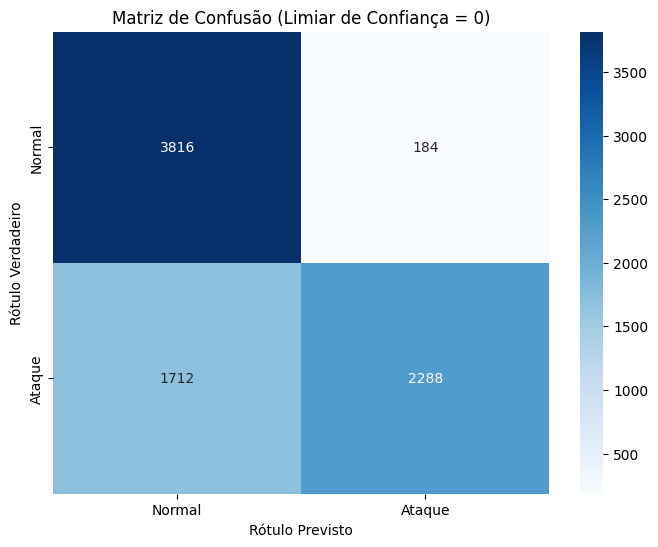

True Positives (TP): 2288
True Negatives (TN): 3816
False Positives (FP): 184
False Negatives (FN): 1712

F1 Score: 0.7070
True Positive Rate (TPR) / Recall: 0.5720
True Negative Rate (TNR) / Specificity: 0.9540
--------------------
Threshold: 0.0000
  Accuracy: 0.7630
  Total Inference Time: 0.0594 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


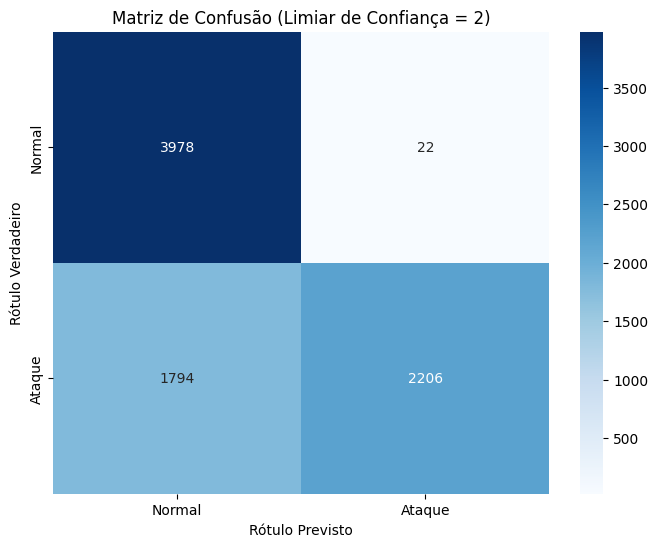

True Positives (TP): 2206
True Negatives (TN): 3978
False Positives (FP): 22
False Negatives (FN): 1794

F1 Score: 0.7084
True Positive Rate (TPR) / Recall: 0.5515
True Negative Rate (TNR) / Specificity: 0.9945
--------------------
Threshold: 2.0000
  Accuracy: 0.7730
  Total Inference Time: 0.0752 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


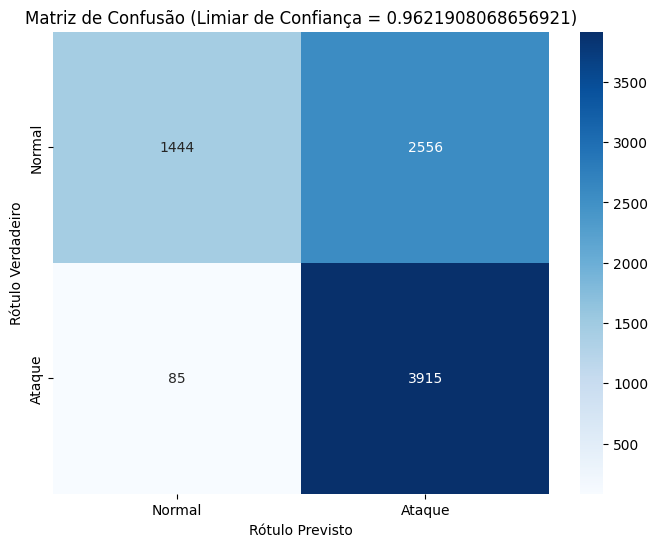

True Positives (TP): 3915
True Negatives (TN): 1444
False Positives (FP): 2556
False Negatives (FN): 85

F1 Score: 0.7478
True Positive Rate (TPR) / Recall: 0.9788
True Negative Rate (TNR) / Specificity: 0.3610
--------------------
Threshold: 0.9622
  Accuracy: 0.6699
  Total Inference Time: 0.2775 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


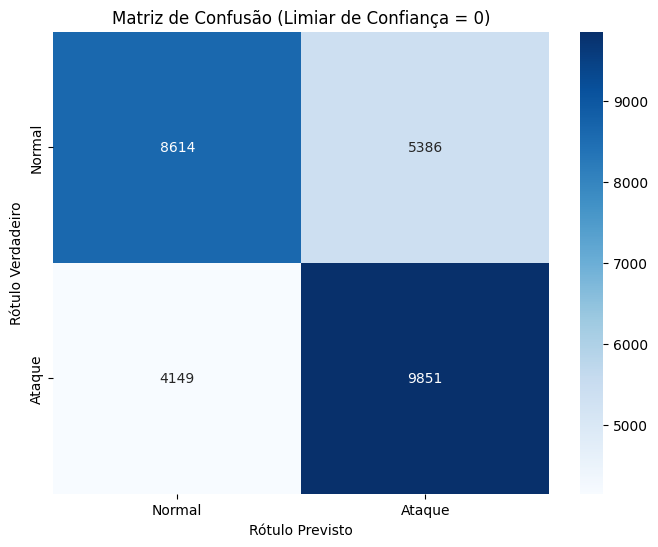

True Positives (TP): 9851
True Negatives (TN): 8614
False Positives (FP): 5386
False Negatives (FN): 4149

F1 Score: 0.6739
True Positive Rate (TPR) / Recall: 0.7036
True Negative Rate (TNR) / Specificity: 0.6153
--------------------
Threshold: 0.0000
  Accuracy: 0.6595
  Total Inference Time: 0.2229 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


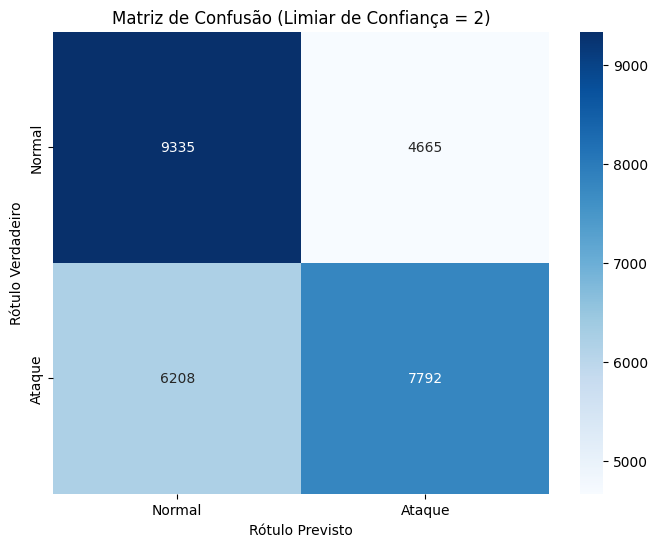

True Positives (TP): 7792
True Negatives (TN): 9335
False Positives (FP): 4665
False Negatives (FN): 6208

F1 Score: 0.5890
True Positive Rate (TPR) / Recall: 0.5566
True Negative Rate (TNR) / Specificity: 0.6668
--------------------
Threshold: 2.0000
  Accuracy: 0.6117
  Total Inference Time: 0.2580 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


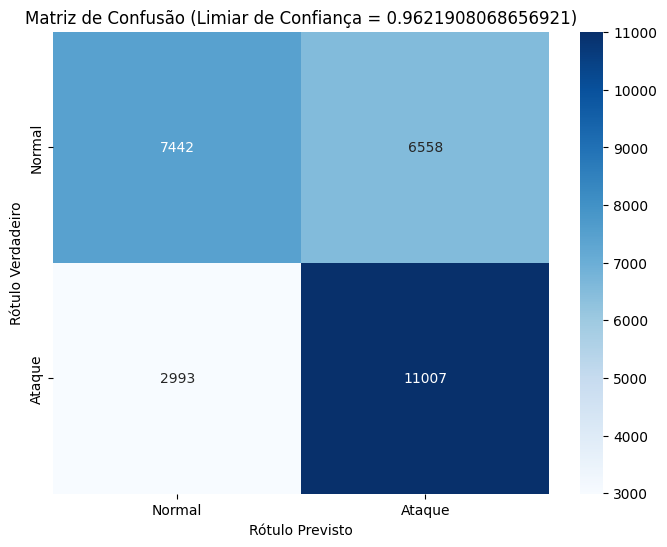

True Positives (TP): 11007
True Negatives (TN): 7442
False Positives (FP): 6558
False Negatives (FN): 2993

F1 Score: 0.6974
True Positive Rate (TPR) / Recall: 0.7862
True Negative Rate (TNR) / Specificity: 0.5316
--------------------
Threshold: 0.9622
  Accuracy: 0.6589
  Total Inference Time: 0.4746 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


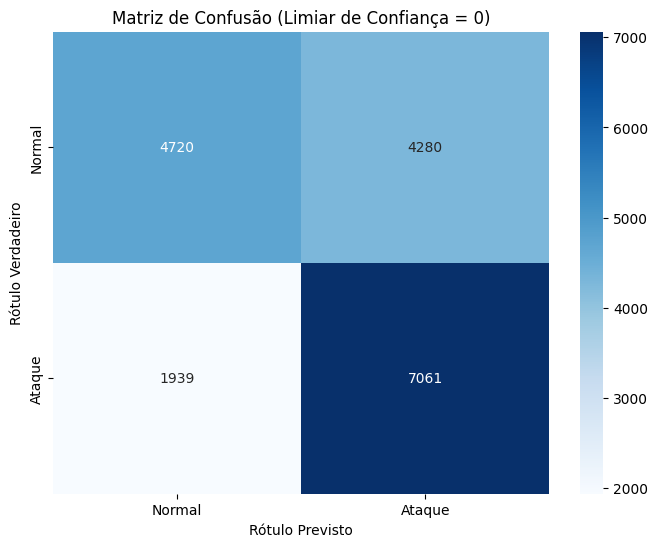

True Positives (TP): 7061
True Negatives (TN): 4720
False Positives (FP): 4280
False Negatives (FN): 1939

F1 Score: 0.6943
True Positive Rate (TPR) / Recall: 0.7846
True Negative Rate (TNR) / Specificity: 0.5244
--------------------
Threshold: 0.0000
  Accuracy: 0.6545
  Total Inference Time: 0.1334 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


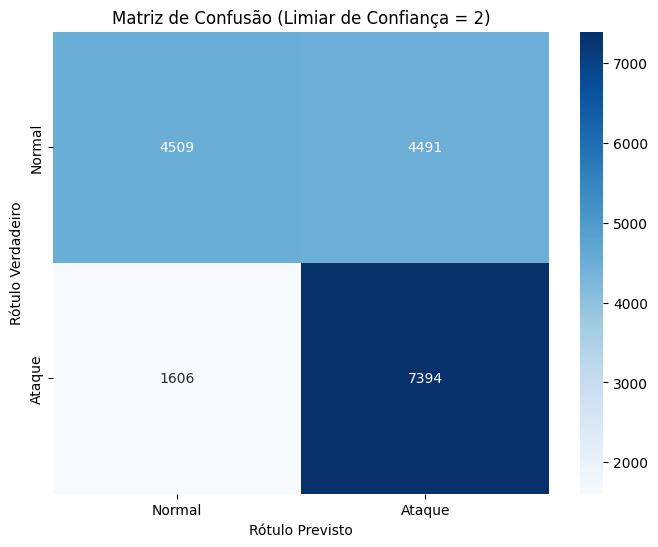

True Positives (TP): 7394
True Negatives (TN): 4509
False Positives (FP): 4491
False Negatives (FN): 1606

F1 Score: 0.7081
True Positive Rate (TPR) / Recall: 0.8216
True Negative Rate (TNR) / Specificity: 0.5010
--------------------
Threshold: 2.0000
  Accuracy: 0.6613
  Total Inference Time: 0.1678 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


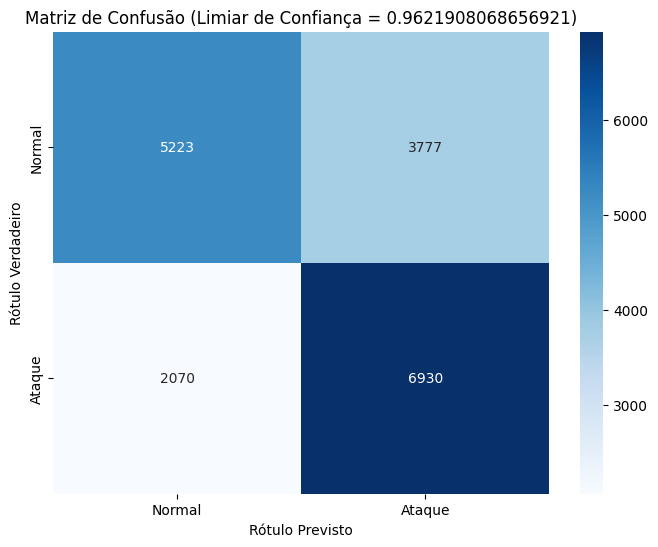

True Positives (TP): 6930
True Negatives (TN): 5223
False Positives (FP): 3777
False Negatives (FN): 2070

F1 Score: 0.7033
True Positive Rate (TPR) / Recall: 0.7700
True Negative Rate (TNR) / Specificity: 0.5803
--------------------
Threshold: 0.9622
  Accuracy: 0.6752
  Total Inference Time: 0.1746 s
  Early Exit Rate: 0.4022 (7240/18000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


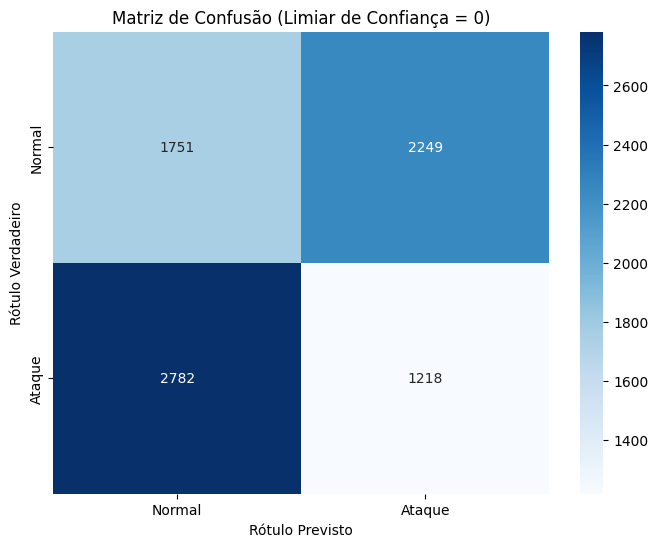

True Positives (TP): 1218
True Negatives (TN): 1751
False Positives (FP): 2249
False Negatives (FN): 2782

F1 Score: 0.3262
True Positive Rate (TPR) / Recall: 0.3045
True Negative Rate (TNR) / Specificity: 0.4377
--------------------
Threshold: 0.0000
  Accuracy: 0.3711
  Total Inference Time: 0.0616 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


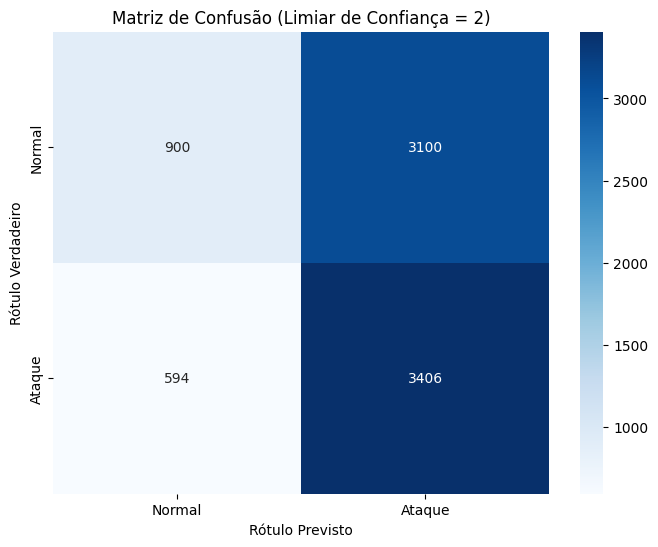

True Positives (TP): 3406
True Negatives (TN): 900
False Positives (FP): 3100
False Negatives (FN): 594

F1 Score: 0.6484
True Positive Rate (TPR) / Recall: 0.8515
True Negative Rate (TNR) / Specificity: 0.2250
--------------------
Threshold: 2.0000
  Accuracy: 0.5383
  Total Inference Time: 0.0761 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


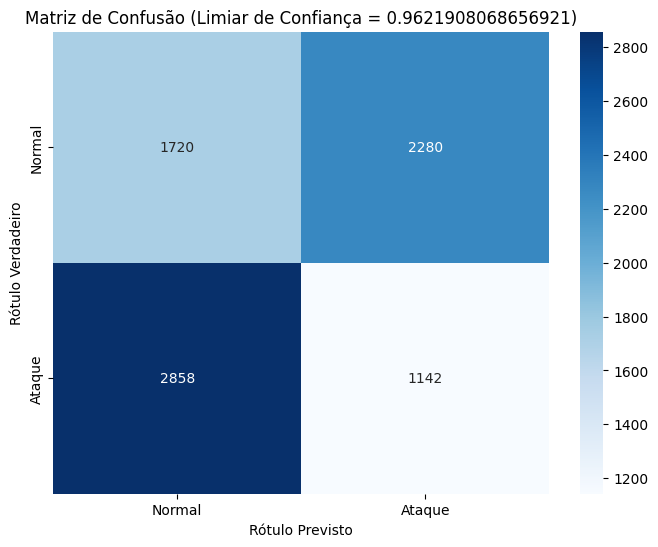

True Positives (TP): 1142
True Negatives (TN): 1720
False Positives (FP): 2280
False Negatives (FN): 2858

F1 Score: 0.3077
True Positive Rate (TPR) / Recall: 0.2855
True Negative Rate (TNR) / Specificity: 0.4300
--------------------
Threshold: 0.9622
  Accuracy: 0.3578
  Total Inference Time: 0.2919 s
  Early Exit Rate: 0.0946 (757/8000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


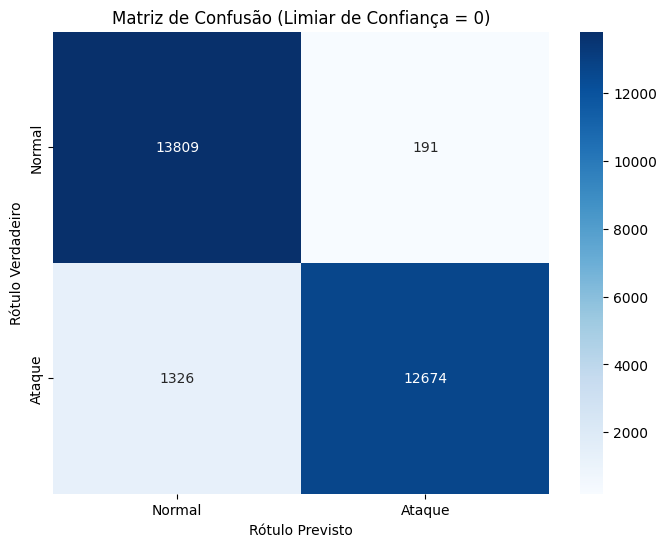

True Positives (TP): 12674
True Negatives (TN): 13809
False Positives (FP): 191
False Negatives (FN): 1326

F1 Score: 0.9435
True Positive Rate (TPR) / Recall: 0.9053
True Negative Rate (TNR) / Specificity: 0.9864
--------------------
Threshold: 0.0000
  Accuracy: 0.9458
  Total Inference Time: 0.2105 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


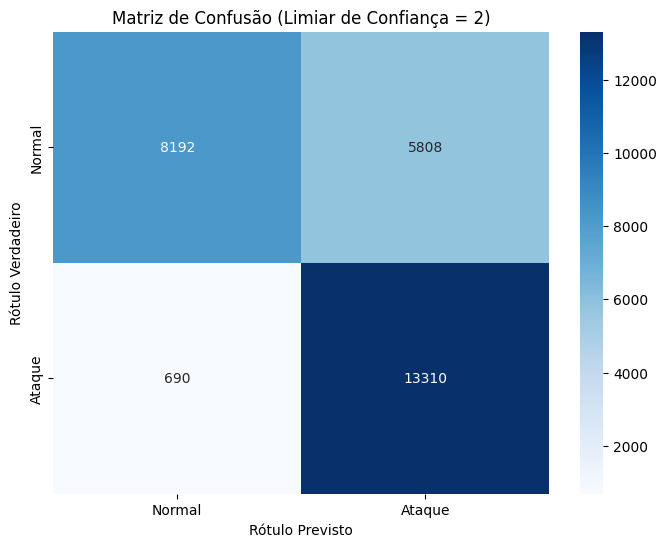

True Positives (TP): 13310
True Negatives (TN): 8192
False Positives (FP): 5808
False Negatives (FN): 690

F1 Score: 0.8038
True Positive Rate (TPR) / Recall: 0.9507
True Negative Rate (TNR) / Specificity: 0.5851
--------------------
Threshold: 2.0000
  Accuracy: 0.7679
  Total Inference Time: 0.2565 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


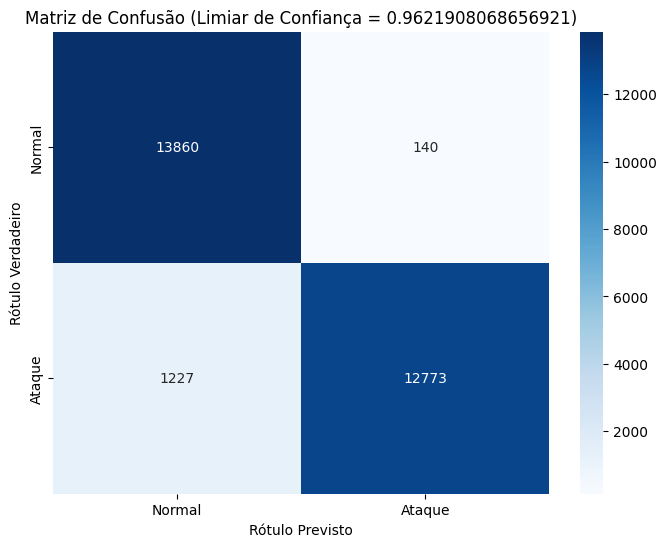

True Positives (TP): 12773
True Negatives (TN): 13860
False Positives (FP): 140
False Negatives (FN): 1227

F1 Score: 0.9492
True Positive Rate (TPR) / Recall: 0.9124
True Negative Rate (TNR) / Specificity: 0.9900
--------------------
Threshold: 0.9622
  Accuracy: 0.9512
  Total Inference Time: 0.4325 s
  Early Exit Rate: 0.3111 (8710/28000)
--------------------




In [22]:
target_exit_rate = 0.20
percentile_threshold = (1 - target_exit_rate) * 100 
global_confs = []

for model_id in range(len(model_names)):
    model = IDSBranchyNet() 
    model.load_state_dict(torch.load(f'models/{model_names[model_id]}_3.pth'))
    model.to(device)
    model.eval()
    
    for loader in range(len(test_loaders)):
        with torch.no_grad():
            for samples, _ in test_loaders[loader]:
                samples = samples.to(device)
                
                branch_output = model.forward_exit1(samples)
                branch_prob = F.softmax(branch_output, dim=1)
                branch_conf, _ = torch.max(branch_prob, 1)
                
                global_confs.append(branch_conf.cpu().numpy())

global_confs = np.concatenate(global_confs)
fixed_threshold_t3 = np.percentile(global_confs, percentile_threshold)

print(f"{fixed_threshold_t3:.4f}")

for model_id in range(len(model_names)):
    for loader in range(len(test_loaders)):
        for test in test_ids:
    
            print(f"--- Model: {model_names[model_id]} | Loader: {model_names[loader]} | TestID: {test} ---")
    
            model.load_state_dict(torch.load(f'models/{model_names[model_id]}_{test}.pth'))
            model.to(device)
            model.eval()
            print(f"Model from: 'models/{model_names[model_id]}_{test}.pth' carregado")

            if test == 1:
                t=0
            elif test == 2:
                t=2
            elif test == 3:
                t=fixed_threshold_t3
    
            results = evaluate_model(model, test_loaders[loader], confidence_threshold=t, device=device)
            
            print("-" * 20)
            print(f"Threshold: {t:.4f}")
            print(f"  Accuracy: {results['accuracy']:.4f}")
            print(f"  Total Inference Time: {results['total_inference_time_sec']:.4f} s")
            print(f"  Early Exit Rate: {results['exit_rate']:.4f} ({results['exited_early_count']}/{results['total_samples']})")
            print("-" * 20)
            print("\n")